# Section 7.4 – Diffusion-Driven Temporal Denoising of Pose Sequences

This notebook simulates a diffusion-style denoising process on signer keypoint sequences by introducing temporally correlated noise and iteratively refining the noisy data to mimic the behavior of SignDiff-like models.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q numpy matplotlib


Mounted at /content/drive


In [13]:
import numpy as np
import matplotlib.pyplot as plt


In [14]:
keypoint_path = "/content/drive/MyDrive/IETGenAI-SLT/Chapter 7/extracted_bring_water_for_me_keypoints.npy"
keypoints = np.load(keypoint_path)
print("Original shape:", keypoints.shape)


Original shape: (47, 99)


In [15]:
def add_temporal_jitter(data, noise_level=0.1, correlation=0.5):
    noisy = data.copy()
    noise = np.random.normal(0, noise_level, data.shape)
    correlated_noise = np.zeros_like(noise)
    correlated_noise[0] = noise[0]
    for t in range(1, len(data)):
        correlated_noise[t] = (1 - correlation) * noise[t] + correlation * correlated_noise[t - 1]
    return noisy + correlated_noise

noisy_kp = add_temporal_jitter(keypoints, noise_level=0.15, correlation=0.6)


In [28]:
def denoise(data, alpha=0.2):
    smoothed = data.copy()
    for i in range(1, len(data)-1):
        smoothed[i] = (1 - alpha) * smoothed[i] + alpha * 0.5 * (smoothed[i-1] + smoothed[i+1])
    return smoothed

intermediates = [noisy_kp.copy()]
denoised = noisy_kp.copy()
for _ in range(5):
    # Changed alpha to 0.8
    denoised = denoise(denoised, alpha=0.8)
    intermediates.append(denoised.copy())

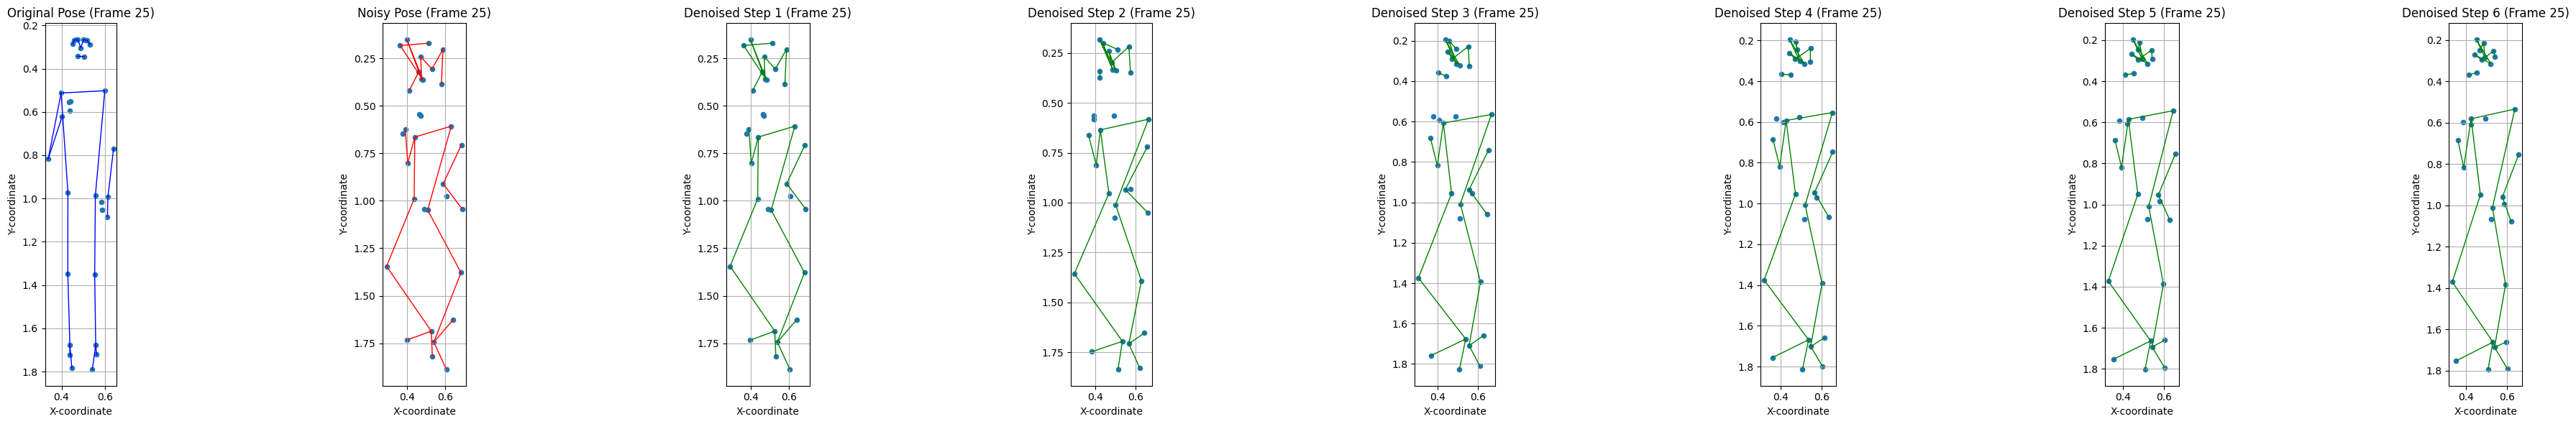

In [29]:
def plot_pose_2d(keypoints_frame, title="Pose", ax=None, connections=None, line_color='k'):
    """Plots a 2D pose from a single frame of keypoint data."""
    if ax is None:
        fig, ax = plt.subplots()

    # Reshape the flat array into keypoints (num_keypoints, 3)
    num_keypoints = keypoints_frame.shape[0] // 3
    keypoints_reshaped = keypoints_frame.reshape((num_keypoints, 3))

    # Extract x and y coordinates
    x_coords = keypoints_reshaped[:, 0]
    y_coords = keypoints_reshaped[:, 1]

    ax.scatter(x_coords, y_coords, s=20)

    # Draw connections
    if connections:
        for i, j in connections:
            # Ensure indices are valid and keypoints are not NaN
            if i < num_keypoints and j < num_keypoints and \
               not (np.isnan(x_coords[i]) or np.isnan(y_coords[i]) or
                    np.isnan(x_coords[j]) or np.isnan(y_coords[j])):
                ax.plot([x_coords[i], x_coords[j]], [y_coords[i], y_coords[j]], color=line_color, linewidth=1)


    ax.set_title(title)
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.set_aspect('equal', adjustable='box') # Maintain aspect ratio
    # Invert y-axis as image coordinates usually have origin at top-left
    ax.invert_yaxis()
    ax.grid(True)


# Define connections between keypoints (from the user's provided code snippet)
pose_connections = [
    (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8), # Head and shoulders
    (9, 10), # Shoulders
    (11, 12), (12, 14), (14, 16), # Right arm
    (13, 15), (15, 17), # Left arm
    (11, 23), (12, 24), # Torso
    (23, 25), (25, 27), (27, 29), (27, 31), # Left leg
    (24, 26), (26, 28), (28, 30), (28, 32) # Right leg
]


# Choose a frame to visualize for 2D poses
frame_idx_2d = 25 # You can change this to any frame between 0 and 46


fig, axes = plt.subplots(1, len(intermediates) + 2, figsize=(5 * (len(intermediates) + 2), 6))

# Plot Original Pose with connections and specified color
plot_pose_2d(keypoints[frame_idx_2d], title=f"Original Pose (Frame {frame_idx_2d})", ax=axes[0], connections=pose_connections, line_color='blue')

# Plot Noisy Pose with connections and specified color
plot_pose_2d(noisy_kp[frame_idx_2d], title=f"Noisy Pose (Frame {frame_idx_2d})", ax=axes[1], connections=pose_connections, line_color='red')

# Plot Denoised Poses with connections and specified color
for i, step in enumerate(intermediates):
    plot_pose_2d(step[frame_idx_2d], title=f"Denoised Step {i+1} (Frame {frame_idx_2d})", ax=axes[i + 2], connections=pose_connections, line_color='green')

plt.tight_layout()
plt.show()

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os

# Mount Google Drive (if not already mounted)
# drive.mount('/content/drive') # Uncomment if you need to remount

# Ensure libraries are installed if necessary (optional, can be run in a separate cell)
# !pip install -q numpy matplotlib

# Load keypoints data
keypoint_path = "/content/drive/MyDrive/IETGenAI-SLT/Chapter 7/extracted_bring_water_for_me_keypoints.npy"

# Check if the file exists before attempting to load
if not os.path.exists(keypoint_path):
    print(f"Error: File not found at {keypoint_path}")
else:
    keypoints = np.load(keypoint_path)
    print("Original shape:", keypoints.shape)

    # Define the add_temporal_jitter function
    def add_temporal_jitter(data, noise_level=0.1, correlation=0.5):
        noisy = data.copy()
        noise = np.random.normal(0, noise_level, data.shape)
        correlated_noise = np.zeros_like(noise)
        correlated_noise[0] = noise[0]
        for t in range(1, len(data)):
            correlated_noise[t] = (1 - correlation) * noise[t] + correlation * correlated_noise[t - 1]
        return noisy + correlated_noise

    # Add temporal jitter
    noisy_kp = add_temporal_jitter(keypoints, noise_level=0.15, correlation=0.6)

    # Define the denoise function
    def denoise(data, alpha=0.2):
        smoothed = data.copy()
        for i in range(1, len(data)-1):
            smoothed[i] = (1 - alpha) * smoothed[i] + alpha * 0.5 * (smoothed[i-1] + smoothed[i+1])
        return smoothed

    # Perform denoising
    intermediates = [noisy_kp.copy()]
    denoised = noisy_kp.copy()
    # You can adjust the number of denoising steps here (e.g., range(10))
    for _ in range(5):
        # Use the desired alpha value (currently 0.8 from previous modification)
        denoised = denoise(denoised, alpha=0.8)
        intermediates.append(denoised.copy())

    # Define the plot_pose_2d function
    def plot_pose_2d(keypoints_frame, title="Pose", ax=None, connections=None, line_color='k'):
        """Plots a 2D pose from a single frame of keypoint data."""
        if ax is None:
            fig, ax = plt.subplots()

        # Reshape the flat array into keypoints (num_keypoints, 3)
        num_keypoints = keypoints_frame.shape[0] // 3
        keypoints_reshaped = keypoints_frame.reshape((num_keypoints, 3))

        # Extract x and y coordinates
        x_coords = keypoints_reshaped[:, 0]
        y_coords = keypoints_reshaped[:, 1]

        ax.scatter(x_coords, y_coords, s=20)

        # Draw connections
        if connections:
            for i, j in connections:
                # Ensure indices are valid and keypoints are not NaN
                if i < num_keypoints and j < num_keypoints and \
                   not (np.isnan(x_coords[i]) or np.isnan(y_coords[i]) or
                        np.isnan(x_coords[j]) or np.isnan(y_coords[j])):
                    ax.plot([x_coords[i], x_coords[j]], [y_coords[i], y_coords[j]], color=line_color, linewidth=1)


        ax.set_title(title)
        ax.set_xlabel("X-coordinate")
        ax.set_ylabel("Y-coordinate")
        ax.set_aspect('equal', adjustable='box') # Maintain aspect ratio
        # Invert y-axis as image coordinates usually have origin at top-left
        ax.invert_yaxis()
        ax.grid(True)

    # Define connections between keypoints (using the mapping provided earlier)
    pose_connections = [
        (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8), # Head and shoulders
        (9, 10), # Shoulders
        (11, 12), (12, 14), (14, 16), # Right arm
        (13, 15), (15, 17), # Left arm
        (11, 23), (12, 24), # Torso
        (23, 25), (25, 27), (27, 29), (27, 31), # Left leg
        (24, 26), (26, 28), (28, 30), (28, 32) # Right leg
    ]


    # Choose a frame to visualize for 2D poses (ensure it's within the valid range 0-46)
    frame_idx_2d = 25

    # Create and display the plots
    fig, axes = plt.subplots(1, len(intermediates) + 2, figsize=(5 * (len(intermediates) + 2), 6))

    # Plot Original Pose with connections and specified color
    plot_pose_2d(keypoints[frame_idx_2d], title=f"Original Pose (Frame {frame_idx_2d})", ax=axes[0], connections=pose_connections, line_color='blue')

    # Plot Noisy Pose with connections and specified color
    plot_pose_2d(noisy_kp[frame_idx_2d], title=f"Noisy Pose (Frame {frame_idx_2d})", ax=axes[1], connections=pose_connections, line_color='red')

    # Plot Denoised Poses with connections and specified color
    for i, step in enumerate(intermediates):
        plot_pose_2d(step[frame_idx_2d], title=f"Denoised Step {i+1} (Frame {frame_idx_2d})", ax=axes[i + 2], connections=pose_connections, line_color='green')

    plt.tight_layout()
    plt.show()